<a href="https://colab.research.google.com/github/bikaneal/ml-thesis/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Применение алгоритма классификации на репликах участников групповых работ**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# С использованием логистической регрессии и мешка слов

Более простой вариант

In [ ]:
!pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 43.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from collections import Counter

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Загружаем и обрабатываем датасет



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Classes/file_upd.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
df

In [ ]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [ ]:
morph = pymorphy3.MorphAnalyzer()
stop_words = stopwords.words('russian')
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»']

In [ ]:
df['preprocessed_text'] = df.apply(lambda row: preprocess(row['text']), axis=1)

In [ ]:
df

,text,category,preprocessed_text
0,Давайте двойку.,предложение,"[давать, двойка]"
1,Ставлю.,предложение,[ставить]
2,Нам надо пять поставить.,предложение,"[пять, поставить]"
3,"Ребят, 2 надо ставить.",предложение,"[ребята, 2, ставить]"
4,"2 надо ставить, у нас ресурсов нет.",предложение,"[2, ставить, ресурс]"
...,...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",другое,"[смотреть, наблюдать, стратегия]"
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",другое,"[варвар, каждый, отправить, ещё, ответ, следую..."
263,Давай,другое,[давать]
264,"Давай, согласна.",другое,"[давать, согласный]"


### Подсчет частоты слов во всех репликах

In [ ]:
words = Counter()

In [ ]:
for phrase in df['preprocessed_text']:
  words.update(phrase)

In [ ]:
words.most_common(10)

[('давать', 49),
 ('поставить', 43),
 ('ставить', 28),
 ('мочь', 27),
 ('остаться', 20),
 ('всё', 20),
 ('команда', 19),
 ('это', 18),
 ('выиграть', 12),
 ('просто', 12)]

###Создаем словарь, упорядоченный по частоте

В словаре будем использовать 2 специальных кода:

* Код заполнитель: 0

* Неизвестное слово: 1

Нумерация в словаре начинается с 2.

In [ ]:
# Словарь, отображающий слова в коды
word_to_index = dict()

# Словарь, отображающий коды в слова
index_to_word = dict()

###Заполняем константы:

In [ ]:
max_words = len(words)
random_state = 42

###Создаем словари

In [ ]:
for i, word in enumerate(words.most_common(max_words - 2)):
  word_to_index[word[0]] = i+2
  index_to_word[i+2] = word[0]

###Функция для преобразования список слов в список кодов

In [ ]:
def text_to_sequence(txt, word_to_index):
  seq = []
  for word in txt:
    index = word_to_index.get(word, 1)
    if index != 1:
      seq.append(index)
  return seq

###Преобразуем все реплики в последовательность кодов

In [ ]:
df['sequences'] = df.apply(lambda row: text_to_sequence(row['preprocessed_text'], word_to_index), axis=1)

In [ ]:
df

,text,category,preprocessed_text,sequences
0,Давайте двойку.,предложение,"[давать, двойка]","[2, 32]"
1,Ставлю.,предложение,[ставить],[4]
2,Нам надо пять поставить.,предложение,"[пять, поставить]","[45, 3]"
3,"Ребят, 2 надо ставить.",предложение,"[ребята, 2, ставить]","[114, 26, 4]"
4,"2 надо ставить, у нас ресурсов нет.",предложение,"[2, ставить, ресурс]","[26, 4, 27]"
...,...,...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",другое,"[смотреть, наблюдать, стратегия]","[12, 409, 33]"
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",другое,"[варвар, каждый, отправить, ещё, ответ, следую...","[198, 410, 78, 16, 43]"
263,Давай,другое,[давать],[2]
264,"Давай, согласна.",другое,"[давать, согласный]","[2, 18]"


## Готовим данные для обучения

###Преобразуем текстовые метрки данных в числовые

In [ ]:
mapping = {'предложение': 1, 'другое': 0}

In [ ]:
df.replace({'category': mapping}, inplace=True)

In [ ]:
df

,text,category,preprocessed_text,sequences
0,Давайте двойку.,1,"[давать, двойка]","[2, 32]"
1,Ставлю.,1,[ставить],[4]
2,Нам надо пять поставить.,1,"[пять, поставить]","[45, 3]"
3,"Ребят, 2 надо ставить.",1,"[ребята, 2, ставить]","[114, 26, 4]"
4,"2 надо ставить, у нас ресурсов нет.",1,"[2, ставить, ресурс]","[26, 4, 27]"
...,...,...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",0,"[смотреть, наблюдать, стратегия]","[12, 409, 33]"
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",0,"[варвар, каждый, отправить, ещё, ответ, следую...","[198, 410, 78, 16, 43]"
263,Давай,0,[давать],[2]
264,"Давай, согласна.",0,"[давать, согласный]","[2, 18]"


###Разделяем метки классов и данные для обучения

In [ ]:
x_train_seq, y_train = df['sequences'], df['category']

###Создаем мешок слов

In [ ]:
def vectorize_sequences(sequences, dimension=len(words)):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    for index in sequence:
      results[i, index] += 1.
  return results

In [ ]:
x_vectors = vectorize_sequences(x_train_seq, max_words)

In [ ]:
x_vectors.shape

(266, 411)

## Создаем модель машинного обучения

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

# Инициализация модели логистической регрессии
lr = LogisticRegression(random_state = 42)

# Создание скорера для f1-score
f1_scorer = make_scorer(f1_score)

# Выполнение кросс-валидации с вычислением f1-score
f1_scores = cross_val_score(lr, x_vectors, y_train, cv=5, scoring=f1_scorer)

# Вывод результатов
print("Средний F1-счет: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))


Средний F1-счет: 0.67 (+/- 0.24)


###Обучаем модель

Для дальнейших предсказаний

In [ ]:
lr.fit(x_vectors, y_train)

LogisticRegression(random_state=42)

## Экспериментальное внедрение модели

In [ ]:
speakers = dict()

In [ ]:
test = open('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/transcript.txt', encoding='utf8').read()
test = test[:-1].split('n')

### Обработка поступаемой реплики

In [ ]:
for i in test:
    speaker, utterance = i.split(': ')
    speaker = speaker.strip() # 'Speaker A'
    utterance = utterance.strip() # '*text*'

    # приводим реплику в нормальный вид и веторизуем

    utterance_preprocessed = preprocess(utterance)
    utterance_seq = text_to_sequence(utterance_preprocessed, word_to_index)
    utterance_bow = vectorize_sequences([utterance_seq], max_words)

    # предсказываем категорию высказывания

    prediction = lr.predict(utterance_bow)

    # добавляем спикера в словарь (если его еще нет)

    if speaker not in speakers:
      speakers[speaker] = []

    # если классификатор распознал реплику как предложение, присваиваем ее спикеру

    if prediction:
      speakers[speaker].append(utterance)

In [ ]:
speakers

{'Speaker A': ['Я, простите, больше не буду без камеры. У нас сейчас важный такт, нам нужно выбрать, кто из нас будет подавать заявки в форуме.',
  'А вот тоже я отправила сообщение тут же. А, ну вы пишете 13, предлагаете, а что насчёт 1, 2, что вы думаете по этому поводу?',
  'Что, мы тогда ставим 21 или другие варианты есть? Так, ну 2... Юля и Анна пишут 21. Галина? 29? Нет, подождите, у них максимум 20 ставка.',
  'Но если они пойдут во банку, у них 20, а мы 21 поставим Ну.',
  'Что команда 2 всегда ставит 20, 22, такие. Мне кажется, надо меньше 10 тоже, я согласна. Это хорошо работает, когда они жгут ресурсы, и потом мы с ними работаем. Мне кажется, или 2, или... Я, конечно, за 2, чтобы они осторожны. Но вторая в начале у них была 23 ставка.',
  'Мне кажется, они пойдут в лобанк, а нужно столько, чтобы перекрыть их.',
  'Давайте сорок пять тогда, да?',
  'Ну тогда давайте единицу.'],
 'Speaker B': ['Да, нужно точно Галина, вы поставите? Спасибо Супер Да, точно.',
  'Мы... Поздравля

In [ ]:
for key, values in speakers.items():
  print(len(values))

8
3
7
0
2


# С помощью векторных представлений слов на обученных моделях

Используем логистическую регрессию и векторные представления Navec.

### Установка и загрузка библиотек

In [ ]:
!pip install pymorphy3
!pip install navec

In [ ]:
import pandas as pd
import numpy as np
import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from navec import Navec

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Константы

In [ ]:
random_state = 42
max_review_len = 50
vector_size = 300

## Загружаем и готовим набор данных

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Classes/file_upd.csv')
dataframe.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
dataframe

,text,category
0,Давайте двойку.,предложение
1,Ставлю.,предложение
2,Нам надо пять поставить.,предложение
3,"Ребят, 2 надо ставить.",предложение
4,"2 надо ставить, у нас ресурсов нет.",предложение
...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",другое
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",другое
263,Давай,другое
264,"Давай, согласна.",другое


In [ ]:
dataframe['preprocessed_text'] = dataframe.apply(lambda row: preprocess(row['text']), axis=1)

In [ ]:
dataframe

,text,category,preprocessed_text
0,Давайте двойку.,предложение,"[давать, двойка]"
1,Ставлю.,предложение,[ставить]
2,Нам надо пять поставить.,предложение,"[пять, поставить]"
3,"Ребят, 2 надо ставить.",предложение,"[ребята, 2, ставить]"
4,"2 надо ставить, у нас ресурсов нет.",предложение,"[2, ставить, ресурс]"
...,...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",другое,"[смотреть, наблюдать, стратегия]"
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",другое,"[варвар, каждый, отправить, ещё, ответ, следую..."
263,Давай,другое,[давать]
264,"Давай, согласна.",другое,"[давать, согласный]"


## Загружаем предварительно обученные векторы Navec

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

--2024-06-07 13:56:31--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  19.3MB/s    in 2.6s    

2024-06-07 13:56:35 (19.3 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

### Векторизуем текст

Функция для векторизации текста

In [ ]:
def vectorize_text(txt, navec, max_review_len):
    unk = navec['<unk>']
    text_embeddings = []
    for tocken in txt:
        embedding = navec.get(tocken, unk)
        text_embeddings.append(embedding)
    # Дополняем или обрезаем реплики для фиксированной длины max_review_len
    l = len(text_embeddings)
    if l > max_review_len:
        text_embeddings = text_embeddings[:max_review_len]
    else:
        text_embeddings.extend([navec['<pad>']] * (max_review_len - l))
    return text_embeddings

Применяем функцию векторизации текста к набору данных

In [ ]:
dataframe['embeddings'] = dataframe.apply(lambda row: vectorize_text(row['preprocessed_text'], navec, max_review_len), axis=1)

In [ ]:
dataframe

,text,category,preprocessed_text,embeddings
0,Давайте двойку.,предложение,"[давать, двойка]","[[-0.20394225, -0.5428032, 0.17268088, -0.5472..."
1,Ставлю.,предложение,[ставить],"[[-0.56923324, -0.3954833, -0.06762549, 0.0721..."
2,Нам надо пять поставить.,предложение,"[пять, поставить]","[[0.1683296, -0.4029474, -0.67731494, 0.000809..."
3,"Ребят, 2 надо ставить.",предложение,"[ребята, 2, ставить]","[[0.56820583, 0.046246283, -0.28193244, 0.5412..."
4,"2 надо ставить, у нас ресурсов нет.",предложение,"[2, ставить, ресурс]","[[0.21431214, 0.37028718, 0.13679631, -0.18653..."
...,...,...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",другое,"[смотреть, наблюдать, стратегия]","[[0.36390617, -0.5678413, -0.24011786, 0.23606..."
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",другое,"[варвар, каждый, отправить, ещё, ответ, следую...","[[-0.55413014, -0.12571354, 0.102926634, 0.271..."
263,Давай,другое,[давать],"[[-0.20394225, -0.5428032, 0.17268088, -0.5472..."
264,"Давай, согласна.",другое,"[давать, согласный]","[[-0.20394225, -0.5428032, 0.17268088, -0.5472..."


## Готовим данные для обучения

Преобразуем текстовые метки классов в числовые

In [ ]:
labels = {'предложение': 1, 'другое': 0}

In [ ]:
dataframe.replace({'category': labels}, inplace=True)

In [ ]:
dataframe

,text,category,preprocessed_text,embeddings
0,Давайте двойку.,1,"[давать, двойка]","[[-0.20394225, -0.5428032, 0.17268088, -0.5472..."
1,Ставлю.,1,[ставить],"[[-0.56923324, -0.3954833, -0.06762549, 0.0721..."
2,Нам надо пять поставить.,1,"[пять, поставить]","[[0.1683296, -0.4029474, -0.67731494, 0.000809..."
3,"Ребят, 2 надо ставить.",1,"[ребята, 2, ставить]","[[0.56820583, 0.046246283, -0.28193244, 0.5412..."
4,"2 надо ставить, у нас ресурсов нет.",1,"[2, ставить, ресурс]","[[0.21431214, 0.37028718, 0.13679631, -0.18653..."
...,...,...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",0,"[смотреть, наблюдать, стратегия]","[[0.36390617, -0.5678413, -0.24011786, 0.23606..."
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",0,"[варвар, каждый, отправить, ещё, ответ, следую...","[[-0.55413014, -0.12571354, 0.102926634, 0.271..."
263,Давай,0,[давать],"[[-0.20394225, -0.5428032, 0.17268088, -0.5472..."
264,"Давай, согласна.",0,"[давать, согласный]","[[-0.20394225, -0.5428032, 0.17268088, -0.5472..."


### Разделяем метки классов и данные для обучения

Данные для обучения

In [ ]:
x_vectors = np.array(dataframe['embeddings'].tolist()).reshape(len(dataframe), vector_size * max_review_len)
y_train = dataframe['category']

In [ ]:
x_vectors.shape

(266, 15000)

Данные для тестирования

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

# Инициализация модели логистической регрессии
lr = LogisticRegression(random_state = random_state)

# Создание скорера для f1-score
f1_scorer = make_scorer(f1_score)

# Выполнение кросс-валидации с вычислением f1-score
f1_scores = cross_val_score(lr, x_vectors, y_train, cv=5, scoring=f1_scorer)

# Вывод результатов
print("Средний F1-счет: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))


Средний F1-счет: 0.63 (+/- 0.19)


## Создаем и обучаем модель машинного обучения

In [ ]:
lr.fit(x_vectors, y_train)

LogisticRegression(random_state=42)

## Применяем модель для определения категории высказывания

In [ ]:
speakers = dict()

In [ ]:
test = open('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/transcript.txt', encoding='utf8').read()
test = test[:-1].split('n')

In [ ]:
for i in test:
    speaker, utterance = str(i).split(': ')
    speaker = speaker.strip() # 'Speaker A'
    utterance = utterance.strip() # '*text*'

    # приводим реплику в нормальный вид и веторизуем

    utterance_preprocessed = preprocess(utterance)
    utterance_vectorized_text = vectorize_text(utterance_preprocessed, navec, max_review_len)
    utterance_vector = np.array(utterance_vectorized_text).reshape(1, vector_size * max_review_len)

    # предсказываем категорию высказывания

    prediction = lr.predict(utterance_vector)

    # добавляем спикера в словарь (если его еще нет)

    if speaker not in speakers:
      speakers[speaker] = []

    # если классификатор распознал реплику как предложение, присваиваем ее спикеру

    if prediction:
      speakers[speaker].append(utterance)


In [ ]:
speakers

{'Speaker A': ['А вот тоже я отправила сообщение тут же. А, ну вы пишете 13, предлагаете, а что насчёт 1, 2, что вы думаете по этому поводу?',
  'Что, мы тогда ставим 21 или другие варианты есть? Так, ну 2... Юля и Анна пишут 21. Галина? 29? Нет, подождите, у них максимум 20 ставка.',
  'У меня предложение поставить 10. Потому что чуть больше, чем половина от их суммы. Потому что если они потратят больше, то у них будет меньше 100% чем у.',
  'Так мы можем всё поставить, мы уже.',
  'Так что ставим 18 и всё.',
  'Что команда 2 всегда ставит 20, 22, такие. Мне кажется, надо меньше 10 тоже, я согласна. Это хорошо работает, когда они жгут ресурсы, и потом мы с ними работаем. Мне кажется, или 2, или... Я, конечно, за 2, чтобы они осторожны. Но вторая в начале у них была 23 ставка.',
  'Так, 5-ая, 1, потом 11. Напишем.',
  'Давайте сорок пять тогда, да?',
  'Ну тогда давайте единицу.'],
 'Speaker B': ['Нас сама отправят.',
  'Точно их выиграем, если поставим 18. У них меньше.'],
 'Speaker C

# Обучение Word2Vec

### Загружаем данные и предобрабатываем их

In [ ]:
mapping = {'предложение': 1, 'другое': 0}

In [ ]:
daf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Classes/file_upd.csv")
daf.drop('Unnamed: 0', inplace=True, axis=1)
daf['preprocessed_text'] = daf.apply(lambda row: preprocess(row['text']), axis=1)
daf.replace({'category': mapping}, inplace=True)

daf

,text,category,preprocessed_text
0,Давайте двойку.,1,"[давать, двойка]"
1,Ставлю.,1,[ставить]
2,Нам надо пять поставить.,1,"[пять, поставить]"
3,"Ребят, 2 надо ставить.",1,"[ребята, 2, ставить]"
4,"2 надо ставить, у нас ресурсов нет.",1,"[2, ставить, ресурс]"
...,...,...,...
261,"Смотрим их, да, и наблюдаем за стратегией других.",0,"[смотреть, наблюдать, стратегия]"
262,"Так, а мне, Варвара, мне надо каждый раз отпра...",0,"[варвар, каждый, отправить, ещё, ответ, следую..."
263,Давай,0,[давать]
264,"Давай, согласна.",0,"[давать, согласный]"


In [ ]:
import gensim.models

In [ ]:
model = gensim.models.Word2Vec(sentences=daf['preprocessed_text'],
                               min_count=5,
                               vector_size=50)

In [ ]:
model.wv['смотреть']

array([ 0.00551305, -0.01678892,  0.01577482,  0.01709652, -0.0192698 ,
        0.00486491,  0.01978836, -0.01513808, -0.01406692, -0.01555239,
        0.01661968, -0.00151052,  0.01839333, -0.01615649,  0.007569  ,
        0.00537288,  0.00163838,  0.00483303, -0.01499473, -0.01884145,
        0.00475364,  0.01234927,  0.01615155,  0.01138769, -0.00159783,
        0.0167132 , -0.0187832 ,  0.00694932,  0.00055218,  0.00773297,
        0.01479465, -0.01358148,  0.01114177, -0.01917262, -0.0017002 ,
       -0.01740555, -0.01005168,  0.01856901, -0.00379332,  0.00586708,
        0.01832627,  0.01779688, -0.0164775 , -0.00593986,  0.01988948,
        0.01016719, -0.00315877, -0.01751079,  0.00591609, -0.01326438],
      dtype=float32)

In [ ]:
model.wv.most_similar('ставить')

[('секунда', 0.251559853553772),
 ('думать', 0.2490353286266327),
 ('решить', 0.20444653928279877),
 ('играть', 0.1975618302822113),
 ('автоматически', 0.1811855286359787),
 ('остаться', 0.17062930762767792),
 ('смотреть', 0.15976767241954803),
 ('маленький', 0.1548241376876831),
 ('25', 0.1471744030714035),
 ('большой', 0.14600369334220886)]

In [ ]:
model.save('word2vec-classification-50')

### Загрузка модели и ее применение

In [ ]:
speakers = dict()

text = open('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/transcript.txt', encoding='utf8').read()
text = text[:-1].split('n')

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec

# Загрузка предобученной модели Word2Vec
model = Word2Vec.load('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/word2vec-classification-50')

# Функция для получения среднего вектора для документа
def document_vector(word2vec_model, doc):
    # Отфильтровываем слова, которых нет в модели
    doc = [word for word in doc if word in word2vec_model.wv]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size, dtype=np.float32)

    # Считаем среднее всех векторов слов документа
    return np.mean(word2vec_model.wv[doc], axis=0)

# Преобразование каждого текста в усредненный вектор
daf['doc_vector'] = daf['preprocessed_text'].apply(lambda doc: document_vector(model, doc))

# Получение массива векторов и меток

x_vectors = np.array(daf['doc_vector'].tolist())
y_labels = daf['category'].values

In [ ]:
import pickle
import numpy as np
from gensim.models import Word2Vec

model = Word2Vec.load('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/word2vec-classification-50')

with open('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import SVC

# Инициализация классификатора SVC
classifier = SVC(probability=True)

# Создание скорера для f1-score
f1_scorer = make_scorer(f1_score)

# Выполнение кросс-валидации с вычислением f1-score
f1_scores = cross_val_score(classifier, x_vectors, y_labels, cv=5, scoring=f1_scorer)

# Вывод результатов
print("Средний F1-счет: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))


Средний F1-счет: 0.62 (+/- 0.24)


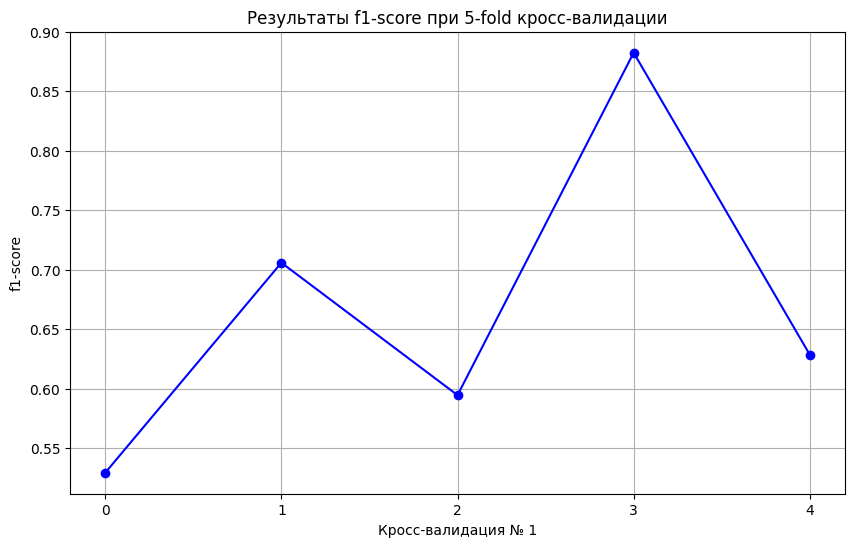

In [ ]:
import matplotlib.pyplot as plt

# Создание графика достижений
plt.figure(figsize=(10, 6))
plt.plot(f1_scores, marker='o', linestyle='-', color='b')
plt.title('Результаты f1-score при 5-fold кросс-валидации')
plt.xlabel('Кросс-валидация № 1')
plt.ylabel('f1-score')
plt.xticks(range(len(f1_scores)))
plt.grid(True)

# Отображение графика
plt.show()

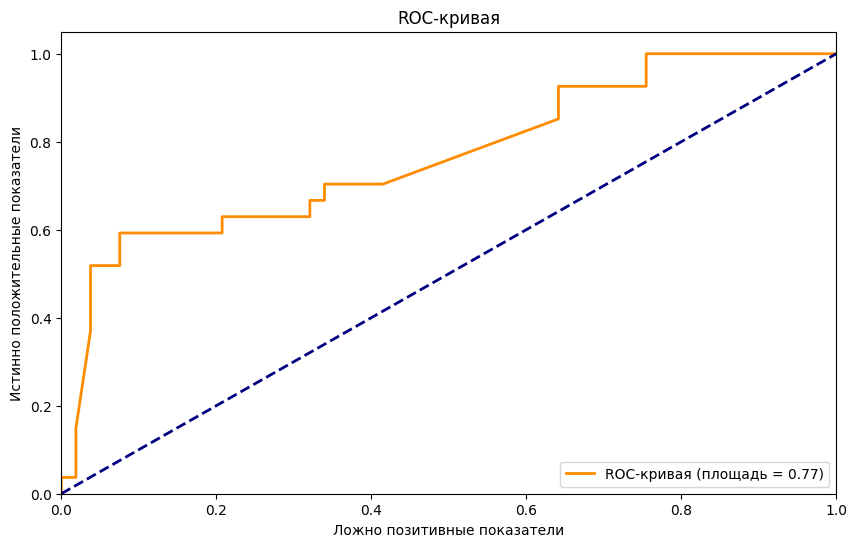

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Разбиение данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(x_vectors, y_labels, test_size=0.3, random_state=42)

# Обучение классификатора
classifier.fit(X_train, y_train)

# Вычисление вероятностей
y_scores = classifier.predict_proba(X_test)[:,1]

# Вычисление TPR и FPR
fpr, tpr, threshold = roc_curve(y_test, y_scores)

# Вычисление площади под кривой
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC-кривая (площадь = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложно позитивные показатели')
plt.ylabel('Истинно положительные показатели')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()


In [ ]:
classifier.fit(x_vectors, y_labels)

import pickle

with open('classifier.pkl', 'wb') as file:
    pickle.dump(classifier, file)

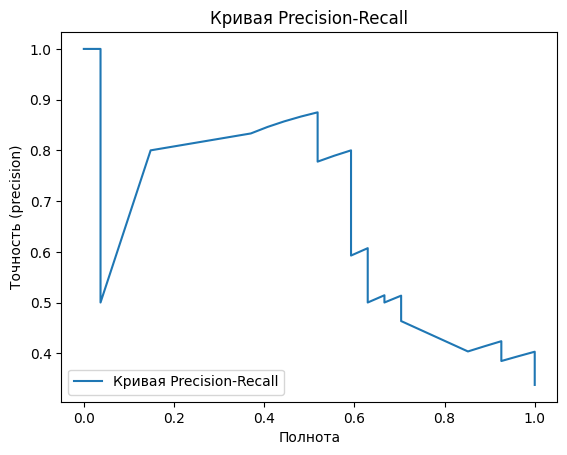

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Предполагается, что X_test - это ваши тестовые данные, а y_test - истинные метки классов
# Предсказываем вероятности классов
y_scores = classifier.decision_function(X_test)

# Вычисляем precision и recall для всех возможных порогов
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

# Рисуем PR кривую
plt.figure()
plt.plot(recall, precision, label='Кривая Precision-Recall')
plt.xlabel('Полнота')
plt.ylabel('Точность (precision)')
plt.title('Кривая Precision-Recall')
plt.legend(loc="lower left")
plt.show()


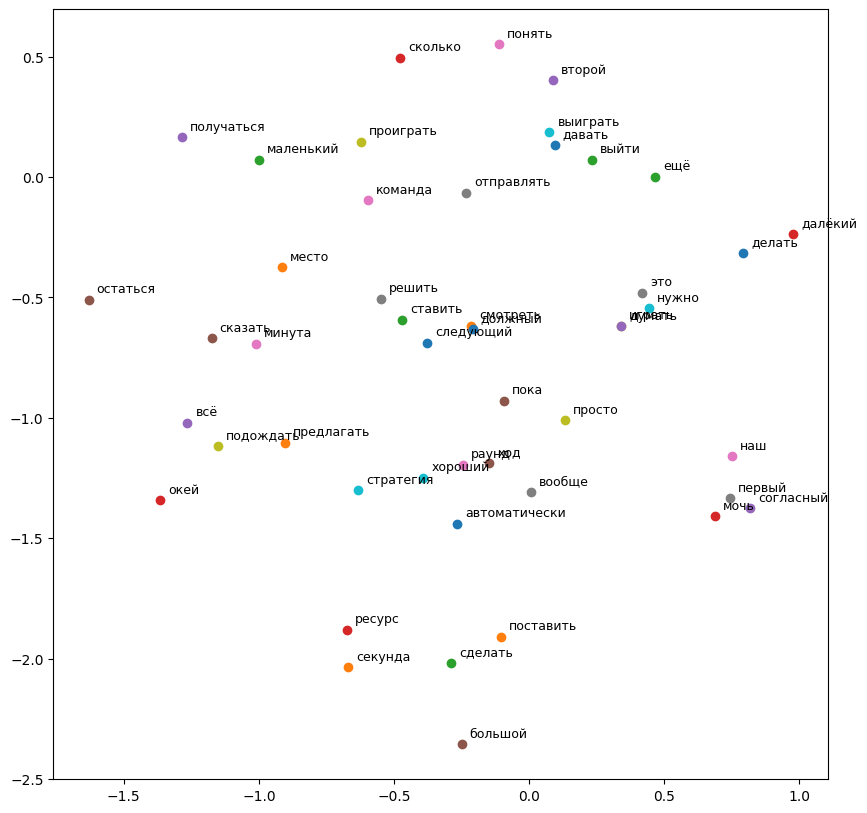

In [ ]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

vectors = [model.wv[word] for word in list(model.wv.key_to_index)[:100]]  # Берем первые 100 слов
words = list(model.wv.key_to_index)[:100]
vectors_array = np.array(vectors)

# Применяем t-SNE
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(vectors_array)

# Визуализация
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.text(vectors_2d[i, 0]+0.03, vectors_2d[i, 1]+0.03, word, fontsize=9)
plt.show()


In [ ]:
words = []

def get_vector(model, tokenized_text):
    return document_vector(model, tokenized_text)

# берем поступаемый текст и разделяем его на части: Speaker N, *реплика этого спикера*

for i in text:
    speaker, utterance = str(i).split(': ')
    utterance = utterance.strip() # '*text*'
    words.append(utterance)

dictionary = {'text': words}
test = pd.DataFrame(dictionary)

test['preprocesed_text'] = test.apply(lambda row: preprocess(row['text']), axis=1)

for i in range(len(text)):
    speaker, utterance = text[i].split(': ')
    speaker = speaker.strip() # 'Speaker A'
    utterance = utterance.strip() # '*text*'

    new_vector = get_vector(model, test['preprocesed_text'][i])
    new_vector = np.array([new_vector])

    prediction = classifier.predict(new_vector)

    if speaker not in speakers:
      speakers[speaker] = []

    if prediction:
      speakers[speaker].append(utterance)

In [ ]:
speakers

{'Speaker A': ['А вот тоже я отправила сообщение тут же. А, ну вы пишете 13, предлагаете, а что насчёт 1, 2, что вы думаете по этому поводу?',
  'Что, мы тогда ставим 21 или другие варианты есть? Так, ну 2... Юля и Анна пишут 21. Галина? 29? Нет, подождите, у них максимум 20 ставка.',
  'Но если они пойдут во банку, у них 20, а мы 21 поставим Ну.',
  'Что команда 2 всегда ставит 20, 22, такие. Мне кажется, надо меньше 10 тоже, я согласна. Это хорошо работает, когда они жгут ресурсы, и потом мы с ними работаем. Мне кажется, или 2, или... Я, конечно, за 2, чтобы они осторожны. Но вторая в начале у них была 23 ставка.',
  'Мне кажется, они пойдут в лобанк, а нужно столько, чтобы перекрыть их.',
  'Давайте сорок пять тогда, да?',
  'Ну тогда давайте единицу.'],
 'Speaker B': ['Мы... Поздравляю в одном шаге от победы. Так, я предлагаю поставить семь.',
  'Да, мы таким же составом. Что, мы снова ставим один?'],
 'Speaker C': ['Я предлагаю начать с минимальных ставок для того, чтобы раскрутит

### Загрузка модели и классификатора для предсказаний

In [ ]:
import pickle
import numpy as np
from gensim.models import Word2Vec

model = Word2Vec.load('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/word2vec-classification-50')

with open('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)

In [ ]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

morph = pymorphy3.MorphAnalyzer()
stop_words = stopwords.words('russian')
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»']

def get_vector(model, tokenized_text):
    return document_vector(model, tokenized_text)

def process_text(text):
    speakers = {}
    if type(text) != list:
      lines = text.split('\n')  # каждая новая строка считается репликой
    else:
      lines = text

    for line in lines:
        if not line.strip():
            continue  # Пропускаем пустые строки

        try:
            speaker, utterance = line.split(': ', 1)
        except ValueError:  # если строка не содержит спикера
            continue

        speaker = speaker.strip()
        utterance = utterance.strip()

        if speaker not in speakers:
            speakers[speaker] = []

        # Предобработка реплики перед подачей в модель
        preprocessed_utterance = preprocess(utterance)

        # Получение вектора для отдельно взятой реплики
        new_vector = get_vector(model, preprocessed_utterance)
        new_vector = np.array([new_vector])

        # Получение предсказания модели
        prediction = classifier.predict(new_vector)

        if prediction:
            # Принадлежность реплики данному спикеру уже гарантирована, добавляем ее в список
            speakers[speaker].append(utterance)

    return speakers

In [ ]:
lines = open('/content/drive/MyDrive/Colab_Notebooks/models/word2vec_class/transcript.txt', encoding='utf8').read()
lines = lines[:-1].split('n')

In [ ]:
process_text(lines)

{'Speaker A': ['А вот тоже я отправила сообщение тут же. А, ну вы пишете 13, предлагаете, а что насчёт 1, 2, что вы думаете по этому поводу?',
  'Что, мы тогда ставим 21 или другие варианты есть? Так, ну 2... Юля и Анна пишут 21. Галина? 29? Нет, подождите, у них максимум 20 ставка.',
  'Но если они пойдут во банку, у них 20, а мы 21 поставим Ну.',
  'Что команда 2 всегда ставит 20, 22, такие. Мне кажется, надо меньше 10 тоже, я согласна. Это хорошо работает, когда они жгут ресурсы, и потом мы с ними работаем. Мне кажется, или 2, или... Я, конечно, за 2, чтобы они осторожны. Но вторая в начале у них была 23 ставка.',
  'Мне кажется, они пойдут в лобанк, а нужно столько, чтобы перекрыть их.',
  'Давайте сорок пять тогда, да?',
  'Ну тогда давайте единицу.'],
 'Speaker B': ['Мы... Поздравляю в одном шаге от победы. Так, я предлагаю поставить семь.',
  'Да, мы таким же составом. Что, мы снова ставим один?'],
 'Speaker C': ['Я предлагаю начать с минимальных ставок для того, чтобы раскрутит